In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

# Image to image matching

## Interpolation implementation

In [2]:
def _match_cumulative_cdf(source, template):

    src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                           return_inverse=True,
                                                           return_counts=True)
    tmpl_values, tmpl_counts = np.unique(template.ravel(), return_counts=True)

    # calculate normalized quantiles for each array
    src_quantiles = np.cumsum(src_counts) / source.size
    tmpl_quantiles = np.cumsum(tmpl_counts) / template.size

    interp_a_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)
    return interp_a_values[src_unique_indices].reshape(source.shape)


def match_histograms(image, reference, *, multichannel=False):

    if image.ndim != reference.ndim:
        raise ValueError('Image and reference must have the same number '
                         'of channels.')
    
    if multichannel:
        matched = np.empty(image.shape, dtype=image.dtype)
        for channel in range(image.shape[-1]):
            matched_channel = _match_cumulative_cdf(image[..., channel],
                                                    reference[..., channel])
            matched[..., channel] = matched_channel
    else:
        matched = _match_cumulative_cdf(image, reference)

    return matched.astype(image.dtype)

## My implementation

In [3]:
def my_match_cumulative_cdf(source, template):
    src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                   return_inverse=True,
                                                   return_counts=True)
    tmpl_values, tmpl_counts = np.unique(template.ravel(), return_counts=True)
    
    nearest_source = (np.cumsum(src_counts)/source.size*255).astype(np.uint8)
    nearest_target = (np.cumsum(tmpl_counts)/template.size*255).astype(np.uint8)
    
    final = np.fromiter((np.argwhere(nearest_target>=ns)[0][0] for ns in nearest_source), np.uint8)
    
    return final[src_unique_indices].reshape(source.shape)
    

def my_match_histograms(image, reference, *, multichannel=False):
    
    if image.ndim != reference.ndim:
        raise ValueError('Image and reference must have the same number '
                         'of channels.')
    
    if multichannel:
        matched = np.empty(image.shape, dtype=image.dtype)
        for channel in range(image.shape[-1]):
            matched_channel = my_match_cumulative_cdf(image[..., channel],
                                                    reference[..., channel])
            matched[..., channel] = matched_channel
    else:
        matched = my_match_cumulative_cdf(image, reference)
        
    return matched

## Test

Let's test on two 512x512 images

In [4]:
img1 = img.imread('./test_images/forest.jpg')
img2 = img.imread('./test_images/sea.jpg')

img1_values, img1_counts = np.unique(img1.ravel(), return_counts=True)
img2_values, img2_counts = np.unique(img2.ravel(), return_counts=True)

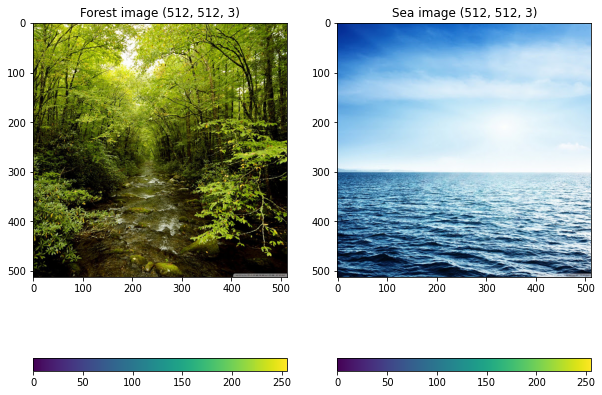

In [5]:
fig, axarr = plt.subplots(1,2, figsize=(10,10))

axarr[0].set_title(f'Forest image {img1.shape}')
show_forest = axarr[0].imshow(img1)
fig.colorbar(show_forest, ax=axarr[0], orientation='horizontal')

axarr[1].set_title(f'Sea image {img2.shape}')
show_sea = axarr[1].imshow(img2)
fig.colorbar(show_sea, ax=axarr[1], orientation='horizontal')

## Test multichannel=False

In [6]:
test1 = match_histograms(img1, img2)
test2 = my_match_histograms(img1, img2)

test1_values, test1_counts = np.unique(test1.ravel(), return_counts=True)
test2_values, test2_counts = np.unique(test2.ravel(), return_counts=True)

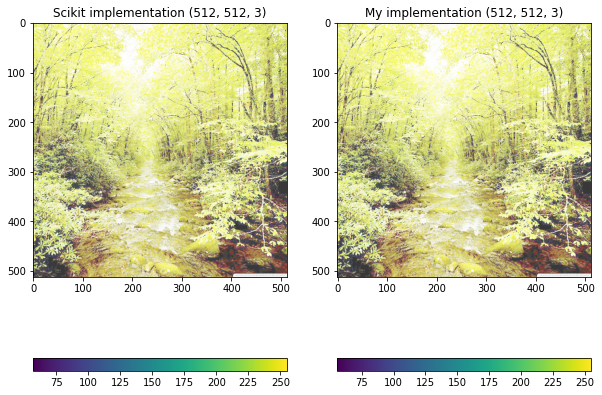

In [7]:
_, axarr = plt.subplots(1,2, figsize=(10,10))

axarr[0].set_title(f'Scikit implementation {test1.shape}')
show_test1 = axarr[0].imshow(test1)
fig.colorbar(show_test1, ax=axarr[0], orientation='horizontal')

axarr[1].set_title(f'My implementation {test2.shape}')
show_test2 = axarr[1].imshow(test2)
fig.colorbar(show_test2, ax=axarr[1], orientation='horizontal')

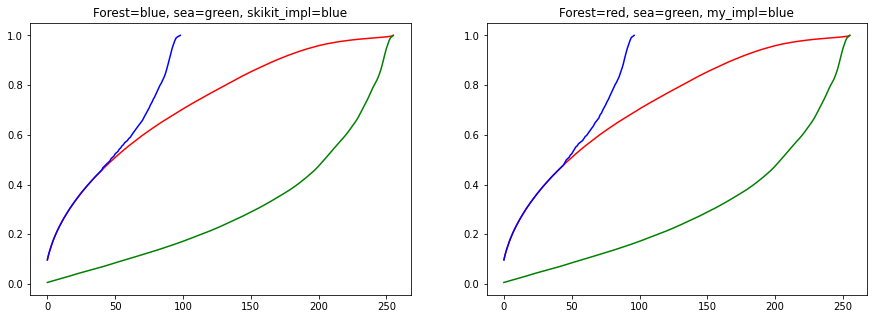

In [8]:
_, axarr = plt.subplots(1,2, figsize=(15,5))

axarr[0].set_title('Forest=blue, sea=green, skikit_impl=blue')
axarr[0].plot(np.cumsum(img1_counts)/img1.size, 'r', 
         np.cumsum(img2_counts)/img2.size, 'g',
         np.cumsum(test1_counts)/test1.size, 'b')

axarr[1].set_title('Forest=red, sea=green, my_impl=blue')
axarr[1].plot(np.cumsum(img1_counts)/img1.size, 'r', 
         np.cumsum(img2_counts)/img2.size, 'g',
         np.cumsum(test2_counts)/test2.size, 'b')

Text(0.5, 1.0, 'my_impl=blue, skikit_impl=red')

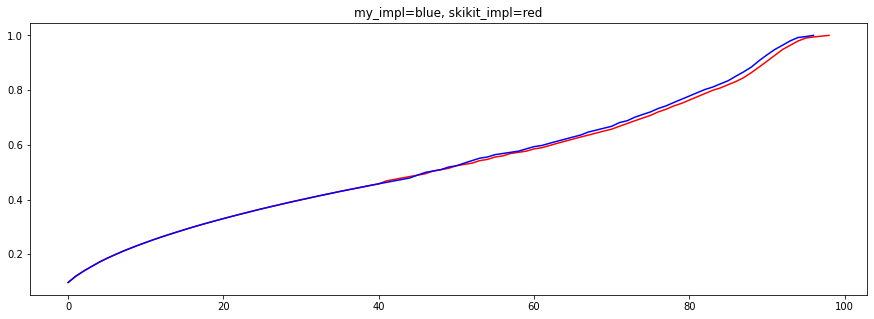

In [9]:
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(test1_counts)/test1.size, 'r')
plt.plot(np.cumsum(test2_counts)/test2.size, 'b')
plt.title('my_impl=blue, skikit_impl=red')

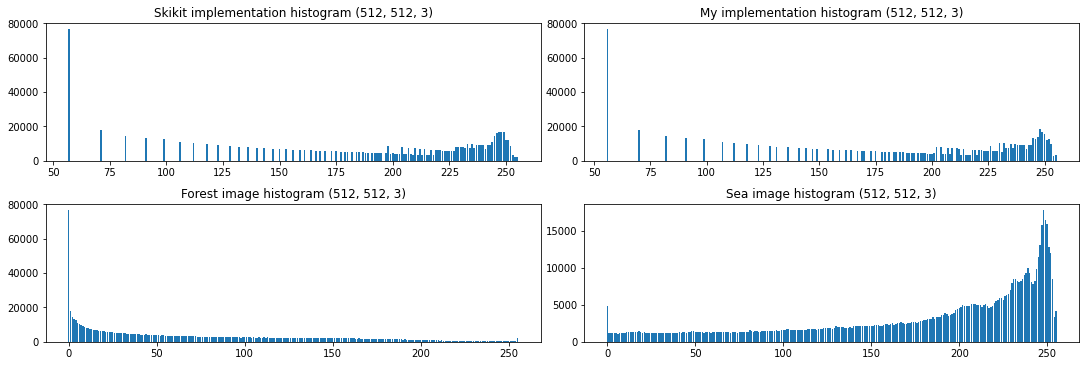

In [10]:
_, axarr = plt.subplots(2,2, figsize=(15,5))

axarr[0,0].set_title(f'Skikit implementation histogram {test1.shape}')
axarr[0,0].bar(test1_values, test1_counts)
axarr[0,1].set_title(f'My implementation histogram {test2.shape}')
axarr[0,1].bar(test2_values, test2_counts)

axarr[1,0].set_title(f'Forest image histogram {img1.shape}')
axarr[1,0].bar(img1_values, img1_counts)
axarr[1,1].set_title(f'Sea image histogram {img2.shape}')
axarr[1,1].bar(img2_values, img2_counts)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Test multichannel=False

In [11]:
test3 = match_histograms(img1, img2, multichannel=True)
test4 = my_match_histograms(img1, img2, multichannel=True)

test3_values, test3_counts = np.unique(test3.ravel(), return_counts=True)
test4_values, test4_counts = np.unique(test4.ravel(), return_counts=True)

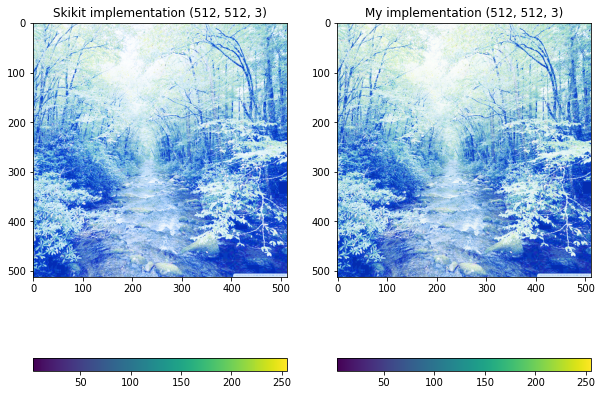

In [12]:
_, axarr = plt.subplots(1,2, figsize=(10,10))

axarr[0].set_title(f'Skikit implementation {test3.shape}')
show_test3 = axarr[0].imshow(test3)
fig.colorbar(show_test3, ax=axarr[0], orientation='horizontal')

axarr[1].set_title(f'My implementation {test4.shape}')
show_test4 = axarr[1].imshow(test4)
fig.colorbar(show_test4, ax=axarr[1], orientation='horizontal')

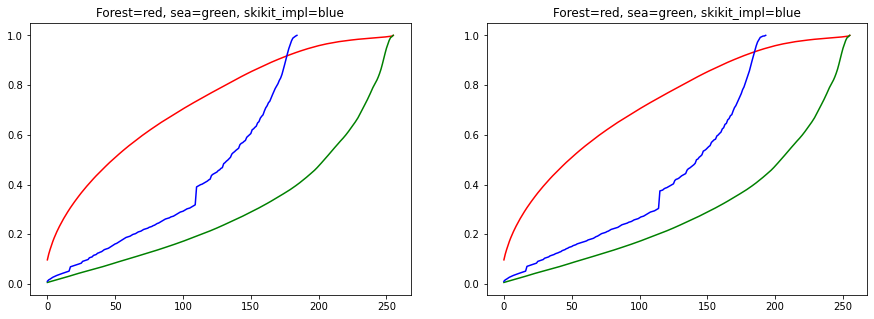

In [13]:
_, axarr = plt.subplots(1,2, figsize=(15,5))

axarr[0].set_title('Forest=red, sea=green, skikit_impl=blue')
axarr[0].plot(np.cumsum(img1_counts)/img1.size, 'r',
         np.cumsum(img2_counts)/img2.size, 'g',
         np.cumsum(test3_counts)/test3.size, 'b')

axarr[1].set_title('Forest=red, sea=green, skikit_impl=blue')
axarr[1].plot(np.cumsum(img1_counts)/img1.size, 'r',
         np.cumsum(img2_counts)/img2.size, 'g',
         np.cumsum(test4_counts)/test4.size, 'b')

Text(0.5, 1.0, 'my_impl=blue, skikit_impl=red')

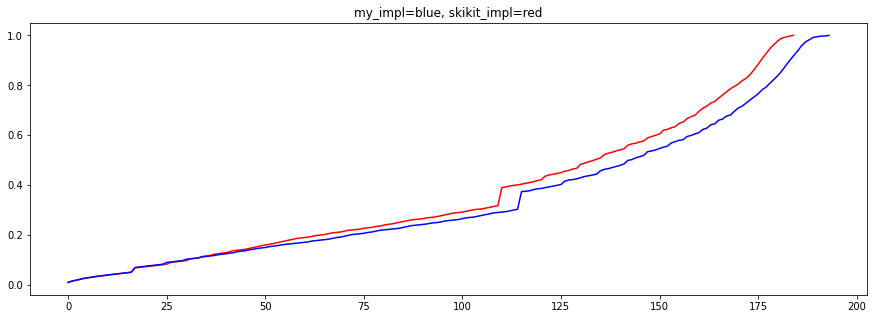

In [14]:
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(test3_counts)/test3.size, 'r')
plt.plot(np.cumsum(test4_counts)/test4.size, 'b')
plt.title('my_impl=blue, skikit_impl=red')

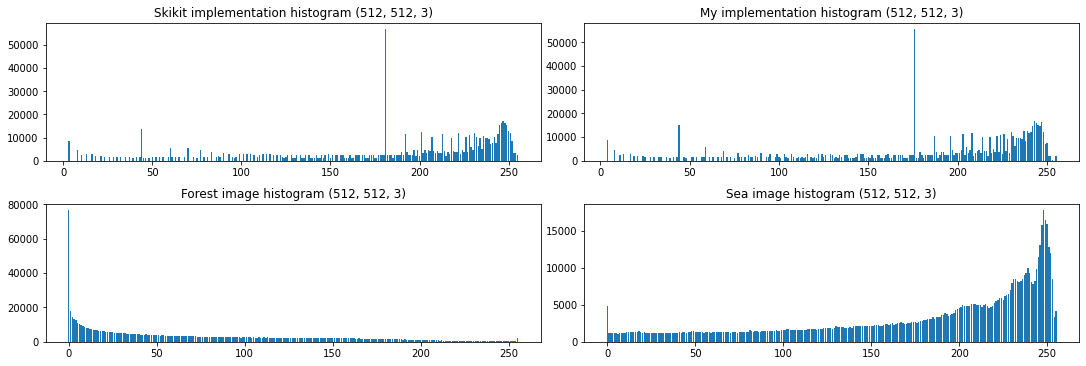

In [15]:
_, axarr = plt.subplots(2,2, figsize=(15,5))

axarr[0,0].set_title(f'Skikit implementation histogram {test1.shape}')
axarr[0,0].bar(test3_values, test3_counts)
axarr[0,1].set_title(f'My implementation histogram {test2.shape}')
axarr[0,1].bar(test4_values, test4_counts)

axarr[1,0].set_title(f'Forest image histogram {img1.shape}')
axarr[1,0].bar(img1_values, img1_counts)
axarr[1,1].set_title(f'Sea image histogram {img2.shape}')
axarr[1,1].bar(img2_values, img2_counts)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Image to histogram matching

## Based on Scikit-image team implementation

In [16]:
def _match_cumulative_cdf2(source, tmpl_values, tmpl_counts):

    src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                           return_inverse=True,
                                                           return_counts=True)

    # calculate normalized quantiles for each array
    src_quantiles = np.cumsum(src_counts) / source.size
    tmpl_quantiles = np.cumsum(tmpl_counts) / np.sum(tmpl_counts)

    interp_a_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)
    return interp_a_values[src_unique_indices].reshape(source.shape)


def match_histograms2(image, tmpl_values, tmpl_counts, *, multichannel=False):

    if multichannel:
        matched = np.empty(image.shape, dtype=image.dtype)
        for channel in range(image.shape[-1]):
            matched_channel = _match_cumulative_cdf2(image[..., channel],
                                                    tmpl_values, 
                                                    tmpl_counts)
            matched[..., channel] = matched_channel
    else:
        matched = _match_cumulative_cdf2(image, tmpl_values, tmpl_counts)

    return matched.astype(np.uint8)

## My implementation

In [17]:
def my_match_cumulative_cdf2(source, tmpl_values, tmpl_counts):
    src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                   return_inverse=True,
                                                   return_counts=True)
    
    nearest_source = (np.cumsum(src_counts)/source.size*255).astype(np.uint8)
    nearest_target = (np.cumsum(tmpl_counts)/np.sum(tmpl_counts)*255).astype(np.uint8)
    
    final = np.fromiter((np.argwhere(nearest_target>=ns)[0][0] for ns in nearest_source), np.uint8)
    
    return final[src_unique_indices].reshape(source.shape)
    

def my_match_histograms2(image, tmpl_values, tmpl_counts, *, multichannel=False):
    
    if multichannel:
        matched = np.empty(image.shape, dtype=image.dtype)
        for channel in range(image.shape[-1]):
            matched_channel = my_match_cumulative_cdf2(image[..., channel],
                                                      tmpl_values, 
                                                      tmpl_counts)
            matched[..., channel] = matched_channel
    else:
        matched = my_match_cumulative_cdf2(image, tmpl_values, tmpl_counts)
        
    return matched

## Test

Let's test on one image and one histogram

In [18]:
mu, sigma = 0, 0.1 # mean and standard deviation
hist = (np.random.normal(mu, sigma, 1000)*256).astype(np.uint8)

hist_values, hist_counts = np.unique(hist, return_counts=True)

<BarContainer object of 129 artists>

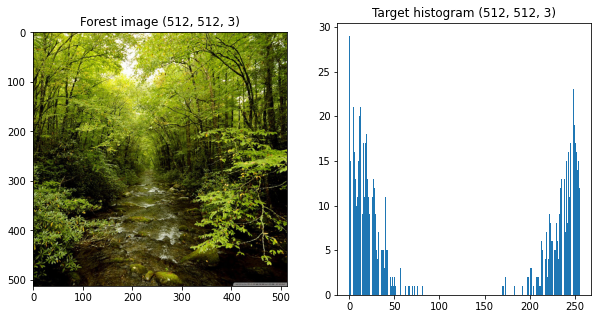

In [19]:
_, axarr = plt.subplots(1,2, figsize=(10,5))
axarr[0].set_title(f'Forest image {img1.shape}')
axarr[0].imshow(img1)

axarr[1].set_title(f'Target histogram {img2.shape}')
axarr[1].bar(hist_values, hist_counts)

## Test multichannel=False

In [20]:
test5 = match_histograms2(img1, hist_values, hist_counts, multichannel=False)
test6 = my_match_histograms2(img1, hist_values, hist_counts, multichannel=False)

test5_values, test5_counts = np.unique(test5.ravel(), return_counts=True)
test6_values, test6_counts = np.unique(test6.ravel(), return_counts=True)

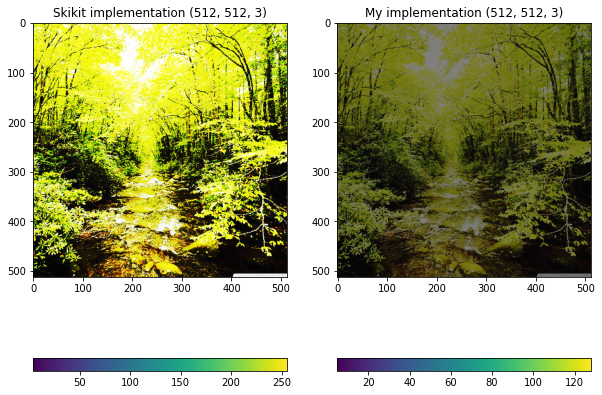

In [21]:
_, axarr = plt.subplots(1,2, figsize=(10,10))

axarr[0].set_title(f'Skikit implementation {test5.shape}')
show_test5 = axarr[0].imshow(test5)
fig.colorbar(show_test5, ax=axarr[0], orientation='horizontal')

axarr[1].set_title(f'My implementation {test6.shape}')
show_test6 = axarr[1].imshow(test6)
fig.colorbar(show_test6, ax=axarr[1], orientation='horizontal')

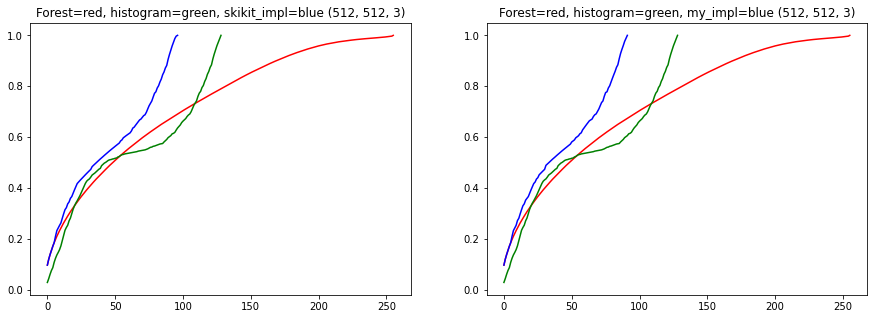

In [22]:
_, axarr = plt.subplots(1,2, figsize=(15,5))

axarr[0].set_title(f'Forest=red, histogram=green, skikit_impl=blue {img1.shape}')
axarr[0].plot(np.cumsum(img1_counts)/img1.size, 'r',
         np.cumsum(hist_counts)/np.sum(hist_counts), 'g',
         np.cumsum(test5_counts)/test5.size, 'b')

axarr[1].set_title(f'Forest=red, histogram=green, my_impl=blue {img2.shape}')
axarr[1].plot(np.cumsum(img1_counts)/img1.size, 'r',
         np.cumsum(hist_counts)/np.sum(hist_counts), 'g',
         np.cumsum(test6_counts)/test6.size, 'b')

Text(0.5, 1.0, 'my_impl=blue, skikit_impl=red')

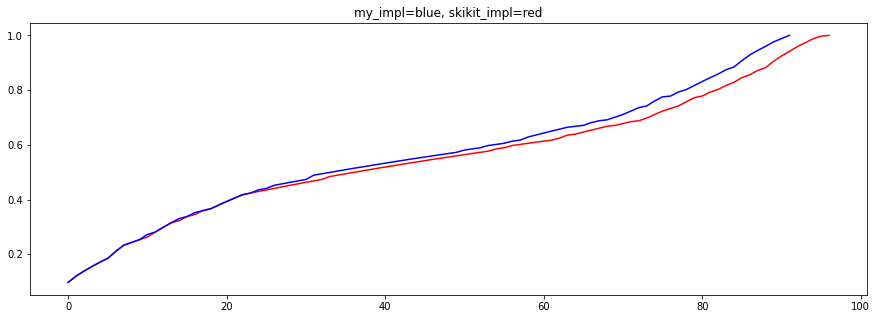

In [23]:
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(test5_counts)/test5.size, 'r')
plt.plot(np.cumsum(test6_counts)/test6.size, 'b')
plt.title('my_impl=blue, skikit_impl=red')

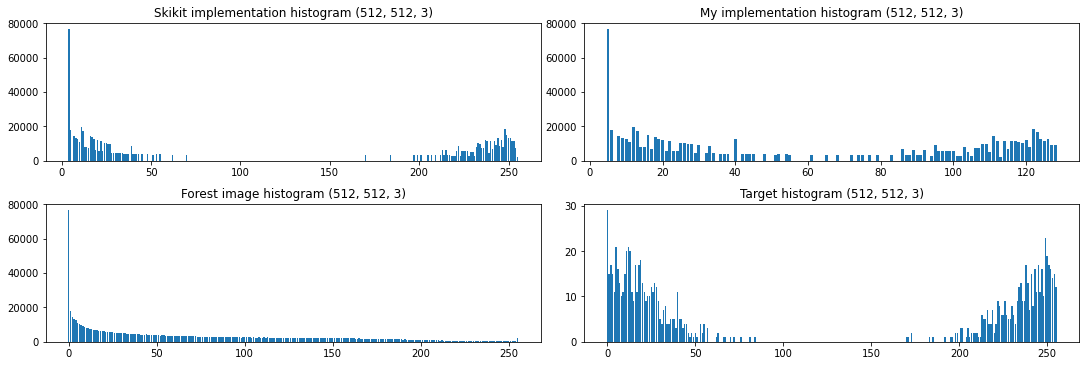

In [24]:
_, axarr = plt.subplots(2,2, figsize=(15,5))

axarr[0,0].set_title(f'Skikit implementation histogram {test1.shape}')
axarr[0,0].bar(test5_values, test5_counts)
axarr[0,1].set_title(f'My implementation histogram {test2.shape}')
axarr[0,1].bar(test6_values, test6_counts)

axarr[1,0].set_title(f'Forest image histogram {img1.shape}')
axarr[1,0].bar(img1_values, img1_counts)
axarr[1,1].set_title(f'Target histogram {img2.shape}')
axarr[1,1].bar(hist_values, hist_counts)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Test multichannel=True

In [25]:
test7 = match_histograms2(img1, hist_values, hist_counts, multichannel=True)
test8 = my_match_histograms2(img1, hist_values, hist_counts, multichannel=True)

test7_values, test7_counts = np.unique(test7.ravel(), return_counts=True)
test8_values, test8_counts = np.unique(test8.ravel(), return_counts=True)

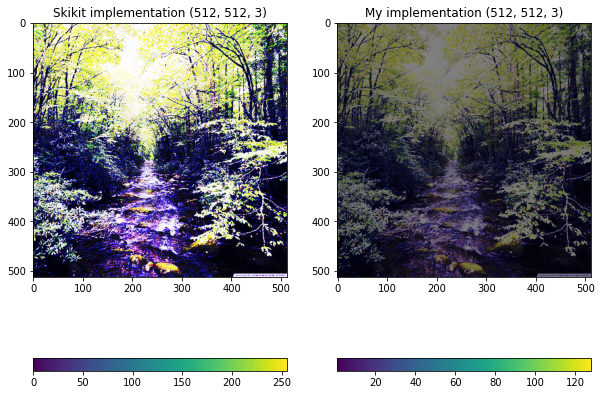

In [26]:
_, axarr = plt.subplots(1,2, figsize=(10,10))

axarr[0].set_title(f'Skikit implementation {test7.shape}')
show_test7 = axarr[0].imshow(test7)
fig.colorbar(show_test7, ax=axarr[0], orientation='horizontal')

axarr[1].set_title(f'My implementation {test8.shape}')
show_test8 = axarr[1].imshow(test8)
fig.colorbar(show_test8, ax=axarr[1], orientation='horizontal')

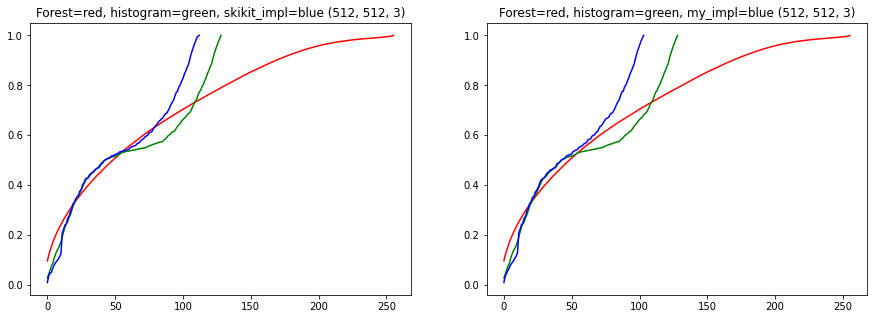

In [27]:
_, axarr = plt.subplots(1,2, figsize=(15,5))
axarr[0].set_title(f'Forest=red, histogram=green, skikit_impl=blue {img1.shape}')
axarr[0].plot(np.cumsum(img1_counts)/img1.size, 'r',
         np.cumsum(hist_counts)/np.sum(hist_counts), 'g',
         np.cumsum(test7_counts)/test7.size, 'b')
axarr[1].set_title(f'Forest=red, histogram=green, my_impl=blue {img2.shape}')
axarr[1].plot(np.cumsum(img1_counts)/img1.size, 'r',
         np.cumsum(hist_counts)/np.sum(hist_counts), 'g',
         np.cumsum(test8_counts)/test8.size, 'b')

Text(0.5, 1.0, 'my_impl=blue, skikit_impl=red')

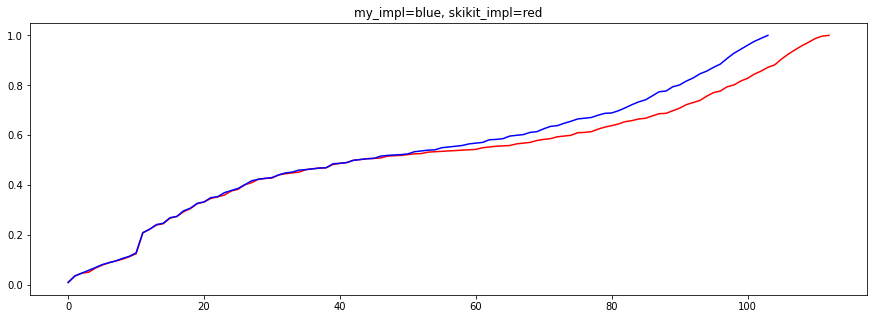

In [28]:
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(test7_counts)/test7.size, 'r')
plt.plot(np.cumsum(test8_counts)/test8.size, 'b')
plt.title('my_impl=blue, skikit_impl=red')

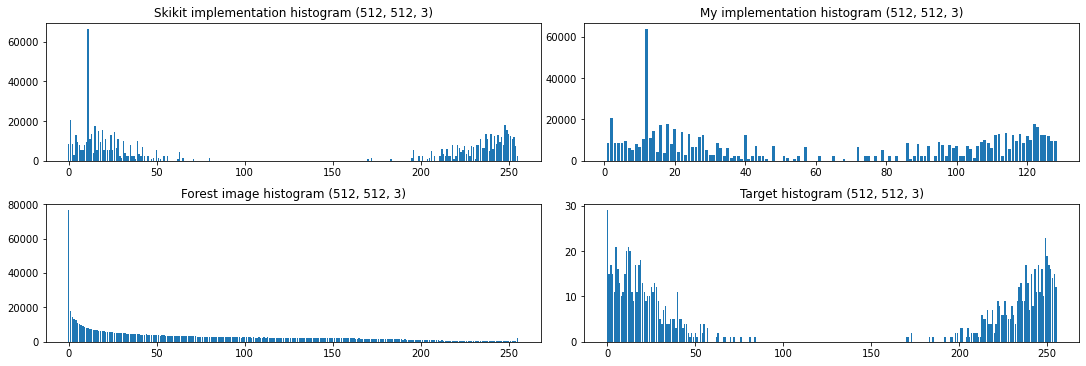

In [29]:
_, axarr = plt.subplots(2,2, figsize=(15,5))
axarr[0,0].set_title(f'Skikit implementation histogram {test1.shape}')
axarr[0,0].bar(test7_values, test7_counts)
axarr[0,1].set_title(f'My implementation histogram {test2.shape}')
axarr[0,1].bar(test8_values, test8_counts)
axarr[1,0].set_title(f'Forest image histogram {img1.shape}')
axarr[1,0].bar(img1_values, img1_counts)
axarr[1,1].set_title(f'Target histogram {img2.shape}')
axarr[1,1].bar(hist_values, hist_counts)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Class implementation

In [30]:
import albumentations as A

class MatchHistograms(A.ImageOnlyTransform):
    
    def __init__(self, tmpl_values=np.arange(256), tmpl_counts=np.random.randint(low=1, high = 1000, size=256), multichannel=True, always_apply=False, p=1.0):
            super(MatchHistograms, self).__init__(always_apply, p)
            self.tmpl_values = tmpl_values
            self.tmpl_counts = tmpl_counts
            self.multichannel = multichannel


    def apply(self, image, **params):
        if self.multichannel:
            matched = np.empty(image.shape, dtype=image.dtype)
            for channel in range(image.shape[-1]):
                matched_channel = my_match_cumulative_cdf2(image[..., channel],
                                                           self.tmpl_values, 
                                                           self.tmpl_counts)
                matched[..., channel] = matched_channel
        else:
            matched = my_match_cumulative_cdf2(image, self.tmpl_values, self.tmpl_counts)

        return matched
    
    
    def match_cumulative_cdf(self, source, tmpl_values, tmpl_counts):
        src_values, src_unique_indices, src_counts = np.unique(source.ravel(),
                                                       return_inverse=True,
                                                       return_counts=True)

        nearest_source = (np.cumsum(src_counts)/source.size*255).astype(np.uint8)
        nearest_target = (np.cumsum(tmpl_counts)/np.sum(tmpl_counts)*255).astype(np.uint8)

        final = np.fromiter((np.argwhere(nearest_target>=ns)[0][0] for ns in nearest_source), np.uint8)

        return final[src_unique_indices].reshape(source.shape)

    
    def get_transform_init_args_names(self):
        return ("tmpl_values", "tmpl_counts", "multichannel")

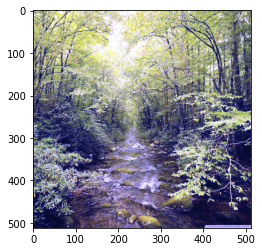

In [31]:
# aug = MatchHistograms(hist_values, hist_counts)
aug = MatchHistograms()
plt.imshow(aug(image=img1)['image'])

In [32]:
aug = A.Compose([
    A.Flip(),
    A.Transpose(),
    MatchHistograms(hist_values, hist_counts),
], p=1)

def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(5, 5))
    plt.imshow(image)

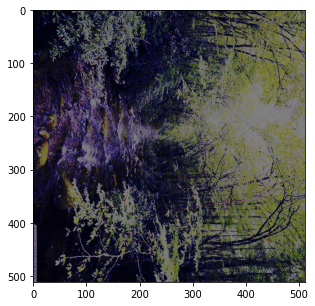

In [33]:
augment_and_show(aug, img1)